In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

- compute spatial covariance per trial
- vectorize covariances
- stack these over trials
- svd of covariance x trial
- unpack and inspect modes, spectrum, etc

In [133]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

In [155]:
subject_idx = 6
subject = subjects[subject_idx]
trials = []
outcomes = []
targets = []
for s in subject.tasks[task_name].sorted_sessions():
    for t in s.sorted_trials():
        if t.outcome != "No Hold":
            trials.append(t)
            outcomes.append(t.outcome)
            targets.append(t.target_number-1)

In [2]:
subject_emg_stacks = np.load("subject_emg_stacks.npy")
subject_emg_stacks.shape

(46, 45, 12, 1072, 64)

In [120]:
emg_stack = subject_emg_stacks[subject_idx]

In [121]:
trial_stack = emg_stack.reshape(-1,1072,64)
trial_stack.shape

(540, 1072, 64)

In [122]:
covariance_stack = []
for trial in trial_stack:
    no_nans = analysis.remove_nan_rows(trial)
    # using fake covariance here to remove mean-subtraction
    covariance_stack.append(analysis.mean_zero_cov(no_nans.T))
    # covariance_stack.append(np.cov(no_nans.T))
covariance_stack = np.array(covariance_stack)
covariance_stack.shape

(540, 64, 64)

In [123]:
def vectorize_covariance(c):
    diag = np.diag(c)
    # scale with sqrt(2) to adjust norm
    tril = c[np.tril_indices_from(c,k=-1)] * np.sqrt(2)
    return np.concatenate([diag, tril])

def unvectorize_covariance(vc,dim):
    # assumes symmetry!
    cov = np.zeros(shape=(dim,dim))
    # diagonal
    # lower triangle
    scale = np.sqrt(2)
    cov[np.tril_indices(dim, -1)] = vc[dim:] / scale
    cov += cov.T
    cov += np.diag(vc[:dim])
    return cov

(4364.921992430105, 4364.921992430105)

In [195]:
# test
dim = 64
x = np.random.normal(2,1,size=(dim,dim))
# symmetric
x += x.T
np.allclose(x, unvectorize_covariance(vectorize_covariance(x),dim),1e-10)

True

In [259]:
cov_vec_stack = []
for cov in covariance_stack:
    cov_vec_stack.append(vectorize_covariance(cov))
cov_vec_stack = np.array(cov_vec_stack)
cov_vec_stack.shape

(540, 2080)

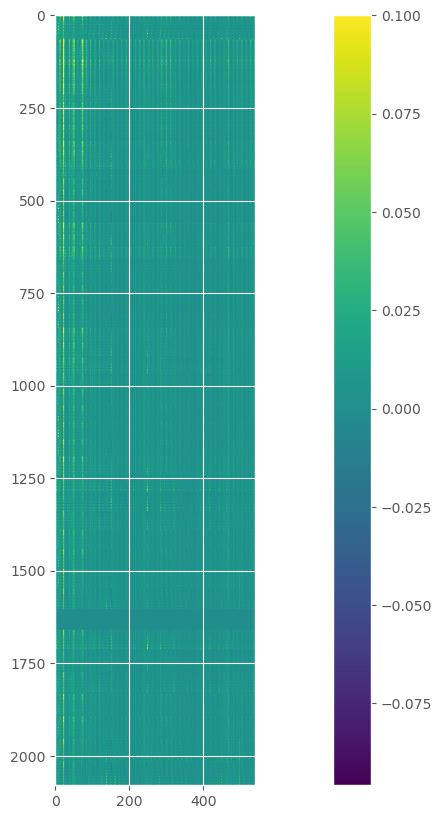

In [260]:
plt.figure(figsize=(20,10))
plt.imshow(cov_vec_stack.T,vmax=0.1)
plt.colorbar()

In [261]:
U, S, V = np.linalg.svd(cov_vec_stack.T)
print(U.shape, S.shape, V.shape)

(2080, 2080) (540,) (540, 540)


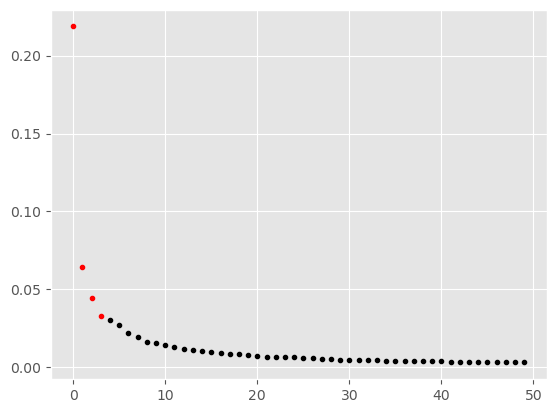

In [269]:
explained_variances = S/S.sum()
num_components = 4
plt.plot(range(num_components,50),explained_variances[num_components:50],"k.")
plt.plot(range(num_components),explained_variances[:num_components],"r.")

In [270]:
trial_weights = V[:num_components,:]
singular_values = S[:num_components]
svd_cov_vecs = U[:,:num_components].T
trial_weights.shape, svd_cov_vecs.shape

((4, 540), (4, 2080))

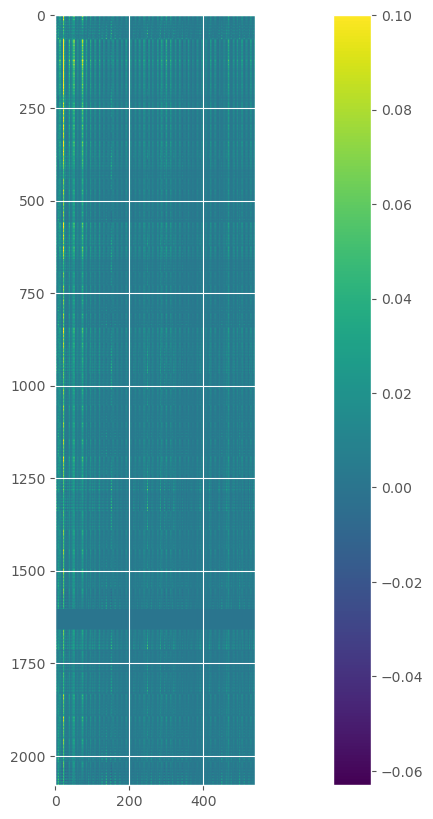

In [271]:
reconstructed = np.zeros_like(cov_vec_stack.T)
for weight, s, vec in zip(trial_weights, singular_values, svd_cov_vecs):
    reconstructed += np.outer(vec*s,weight)

plt.figure(figsize=(20,10))
plt.imshow(reconstructed,vmax=0.1)
plt.colorbar()

By eye we can see that we're getting less variance over trials...?

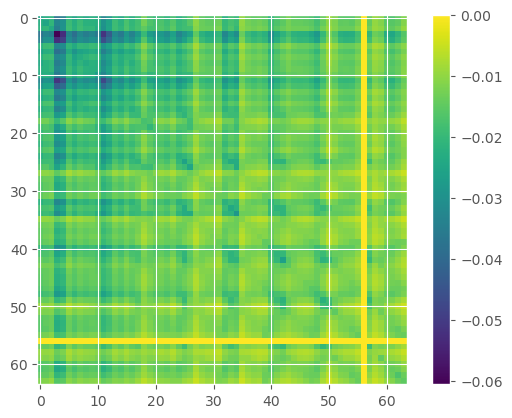

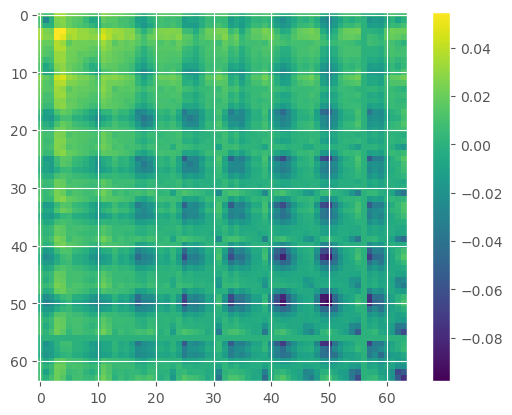

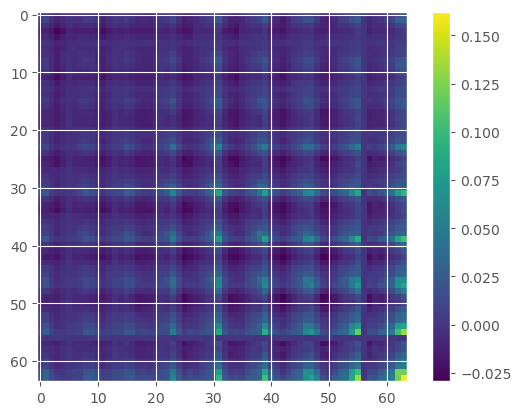

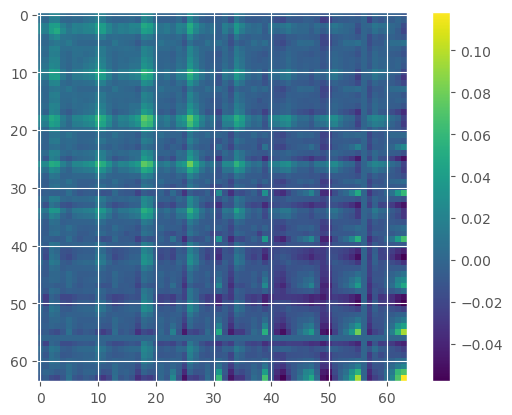

In [272]:
svd_covs = []
for cov_vec in svd_cov_vecs:
    cov = unvectorize_covariance(cov_vec,64)
    svd_covs.append(cov)
    plt.figure()
    plt.imshow(cov)#,vmin=-1,vmax=1)
    plt.colorbar()

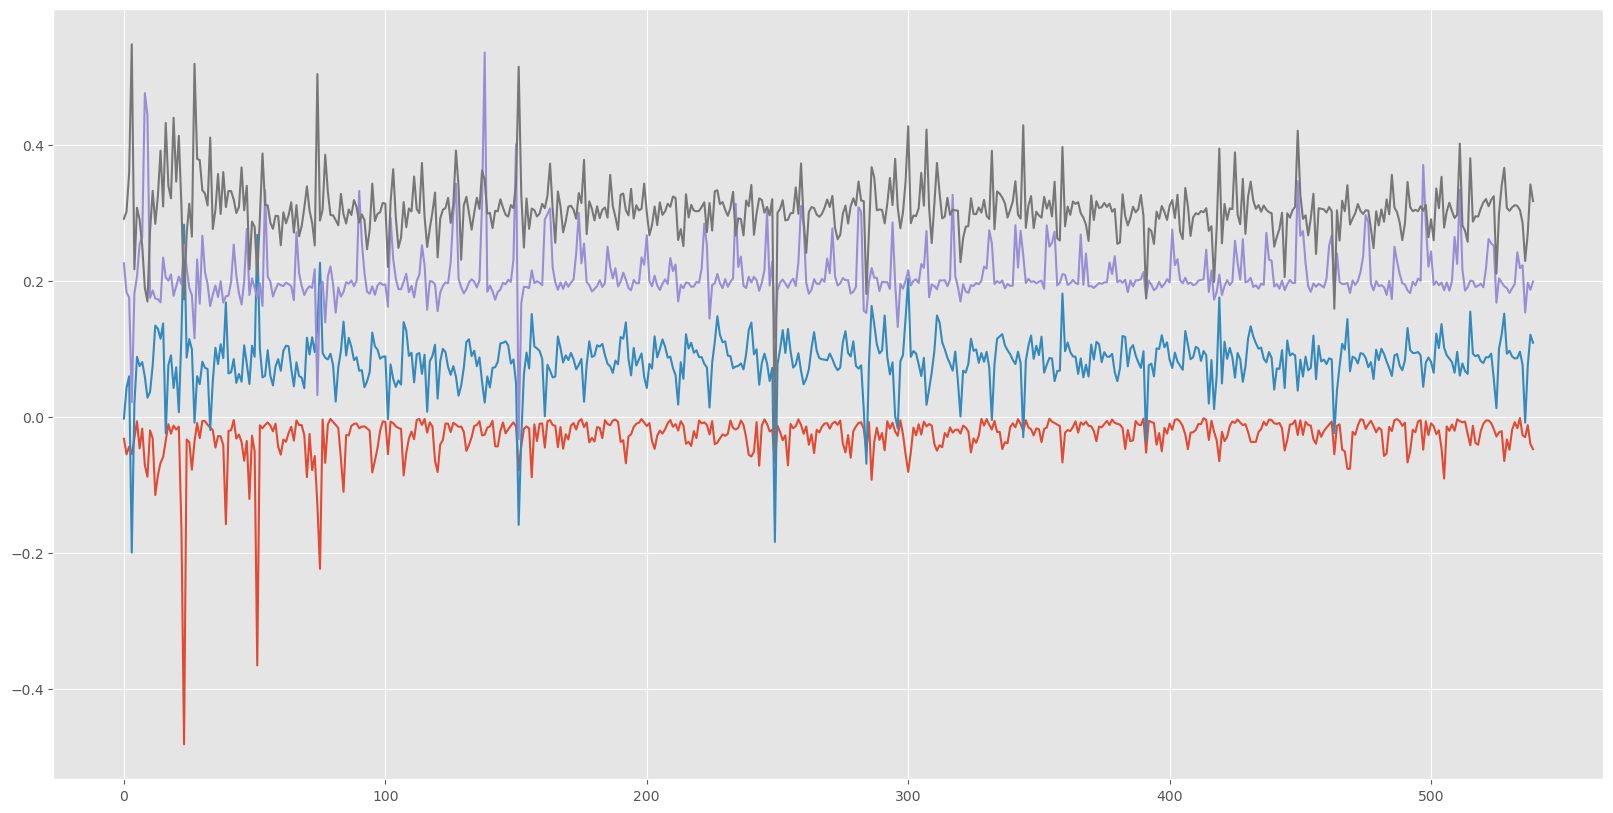

In [273]:
plt.figure(figsize=(20,10))
for i, w in enumerate(trial_weights):
    plt.plot(w+i*0.1)
# plt.ylim([-0.1,0.1])

In [274]:
# trial, target, cov/component
cov_trial_weights_over_targets = np.zeros(shape=(45,12,num_components))
for target_idx in range(12):
    block_idx = 0
    # which trial this target happened on
    for trial_target_idx, trial_target in enumerate(targets):
        # found the target we're looking for
        if target_idx == trial_target:
            # take all the weights from this trial
            cov_trial_weights_over_targets[block_idx, target_idx, :] = trial_weights[:,trial_target_idx]
            # next block
            block_idx += 1

## covariance "mode" weights over trials for each target

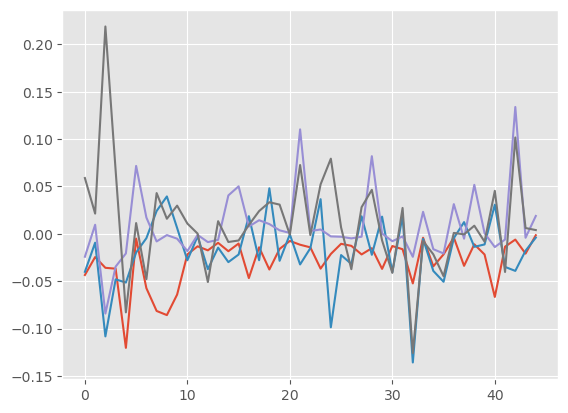

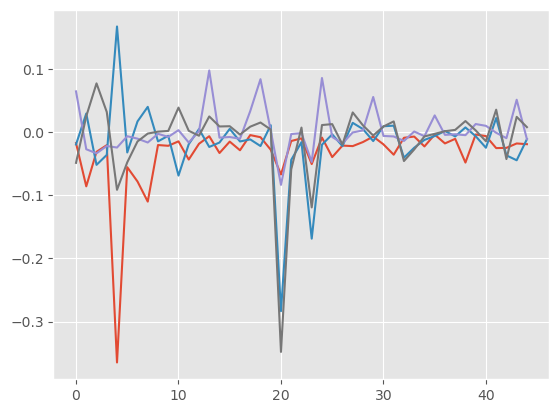

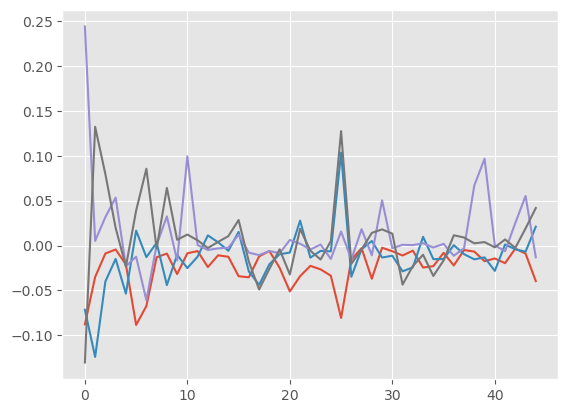

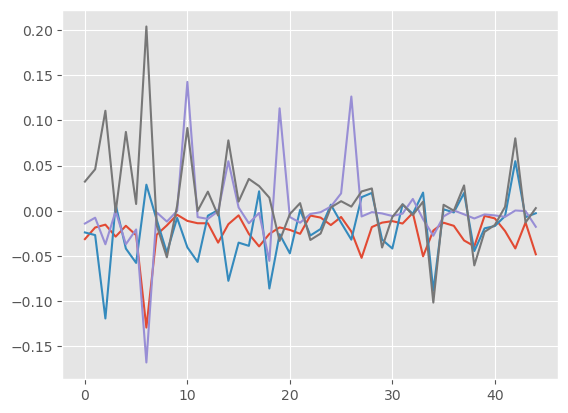

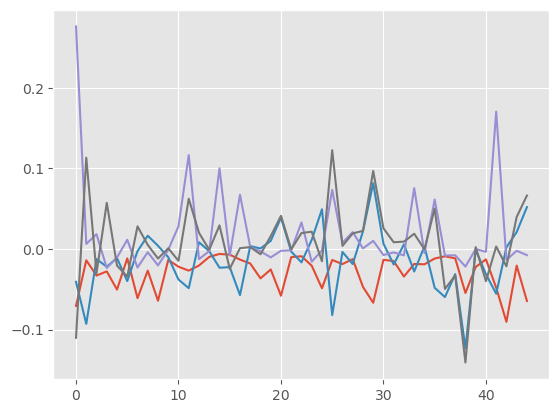

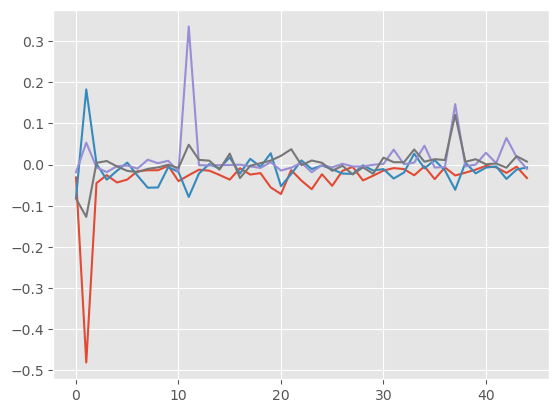

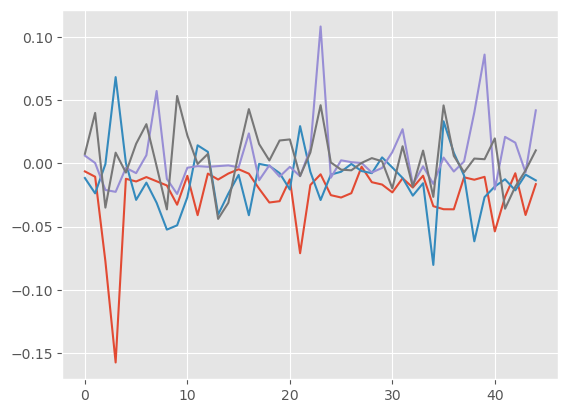

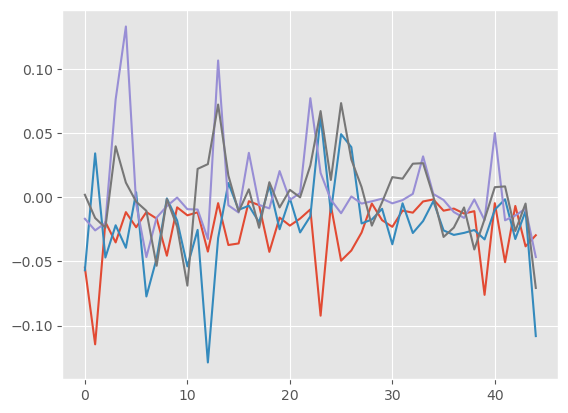

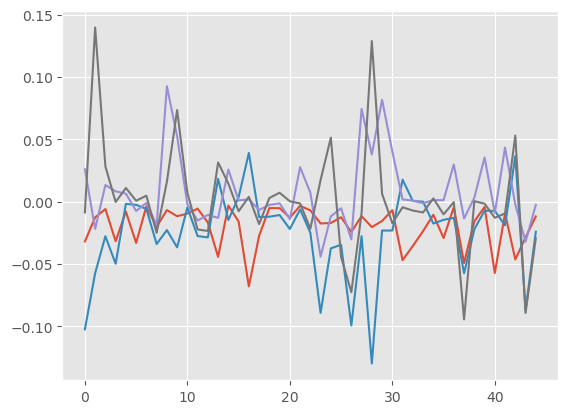

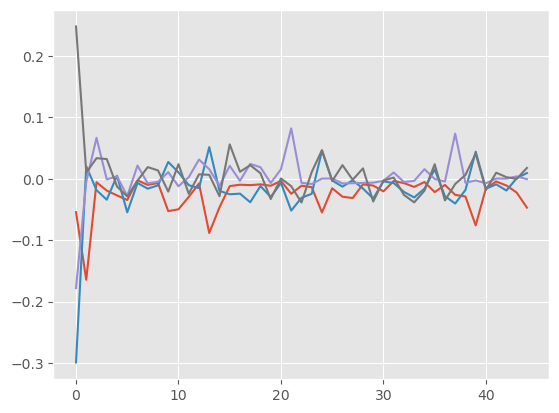

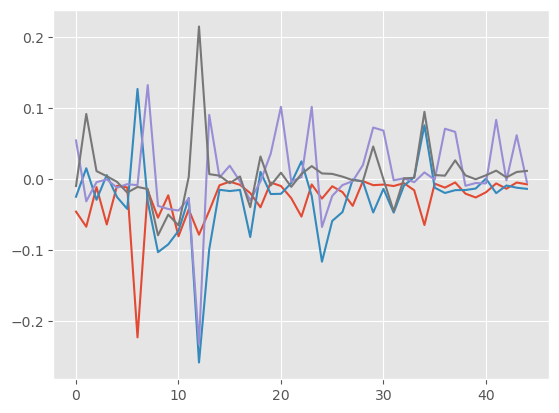

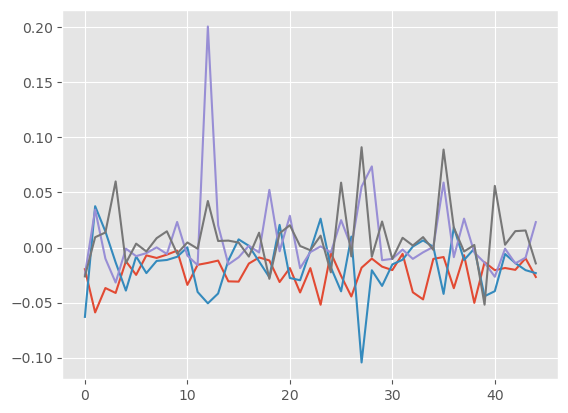

In [278]:
for target_idx in range(12):
    plt.figure()
    for weight_idx in range(num_components):
        plt.plot(range(45), cov_trial_weights_over_targets[:,target_idx,weight_idx])

In [ ]:
# we can think of each of these as a gaussian "mode" with rank-1 covariance, and sample from the mixture, using the singular value as the mixture weight?

gmm = GaussianMixture(n_components=2)
gmm.weights_ = np.array(weights)
gmm.means_ = np.array(means)
gmm.covariances_ = np.array([Xsum, X])
